In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
def load_dataset(dataset_path):
    data = []
    labels = []
    categories = ['compliant', 'non-compliant']
    
    for category in categories:
        path = os.path.join(dataset_path, category)
        label = categories.index(category)
        
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (224, 224))  # Resize for MobileNetV2 or EfficientNet
            data.append(image)
            labels.append(label)
    
    return np.array(data), np.array(labels)

In [3]:
dataset_path = 'SF-MASK' 
train_dir = 'SF-MASK/train'
test_dir = 'SF-MASK/test'

Found 37156 images belonging to 2 classes.
Found 8670 images belonging to 2 classes.
Epoch 1/10


2024-11-28 16:45:39.400227: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1162/1162 [==============================] - 342s 294ms/step - loss: 0.4218 - accuracy: 0.8042 - val_loss: 0.4123 - val_accuracy: 0.8114
Epoch 2/10
1162/1162 [==============================] - 359s 309ms/step - loss: 0.3738 - accuracy: 0.8294 - val_loss: 0.3945 - val_accuracy: 0.8258
Epoch 3/10
1162/1162 [==============================] - 730s 628ms/step - loss: 0.3586 - accuracy: 0.8378 - val_loss: 0.3786 - val_accuracy: 0.8368
Epoch 4/10
1162/1162 [==============================] - 344s 296ms/step - loss: 0.3451 - accuracy: 0.8427 - val_loss: 0.3731 - val_accuracy: 0.8379
Epoch 5/10
1162/1162 [==============================] - 416s 358ms/step - loss: 0.3444 - accuracy: 0.8429 - val_loss: 0.3969 - val_accuracy: 0.8255
Epoch 6/10
1162/1162 [==============================] - 408s 351ms/step - loss: 0.3350 - accuracy: 0.8504 - val_loss: 0.3722 - val_accuracy: 0.8351
Epoch 7/10
1162/1162 [==============================] - 357s 307ms/step - loss: 0.3308 - accuracy: 0.8517 - val_loss: 0.355

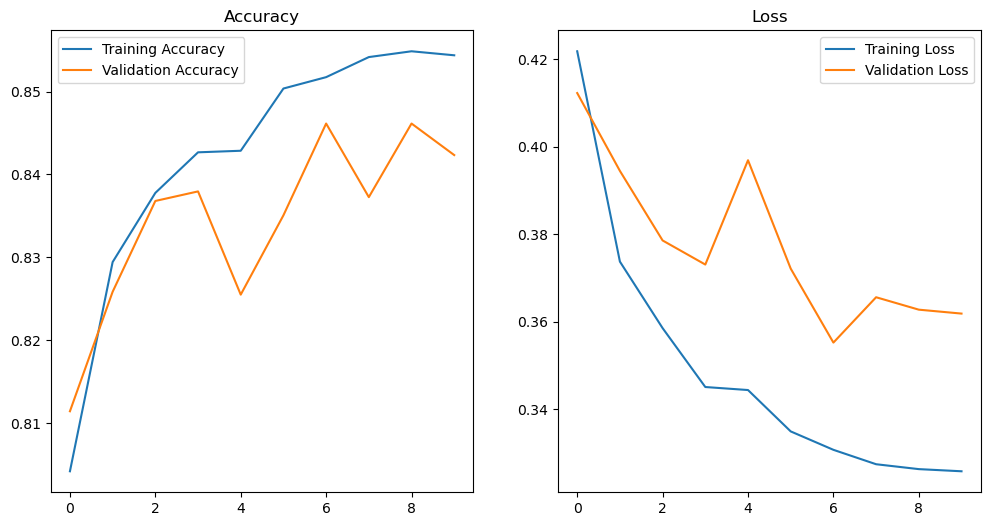

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Chargement des données
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Charger MobileNetV2 pré-entraîné
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Construire le modèle
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    verbose=1
)

# Évaluer le modèle
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
print(classification_report(test_generator.classes, y_pred, target_names=['Compliant', 'Non-Compliant']))

# Sauvegarder le modèle
model.save("mask_detector_model.h5")

# Afficher les courbes d'apprentissage
def plot_training(history):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    
    plt.show()

plot_training(history)
